# Read in all the relevant data

In [1]:
import pandas as pd
df_1 = pd.read_excel("Health-Centers-Albany-250Miles.xlsx")
df_2 = pd.read_excel("Health-Centers-Clinton-250Miles.xlsx")
all_nys_health_facilities = pd.concat([df_1,df_2]).drop_duplicates().reset_index(drop=True)

all_nys_health_facilities[['zip','zip4']] = all_nys_health_facilities['ZIP Code'].str.split('-',expand=True)
all_nys_health_facilities['zip'] = all_nys_health_facilities['zip'].astype(int)

visn_2_eastern_facilities = pd.read_csv("VISN 02 Eastern Facilities.txt", sep = "\t")
visn_2_eastern_facilities[['Address','zip']] = visn_2_eastern_facilities['Address'].str.split(', NY ',expand=True)
visn_2_eastern_facilities = visn_2_eastern_facilities[['City', 'zip']] 
visn_2_eastern_facilities.zip = visn_2_eastern_facilities.zip.astype(str)
visn_2_eastern_facilities = visn_2_eastern_facilities[visn_2_eastern_facilities.zip!= "13733"]
visn_2_eastern_enrollee_county = pd.read_excel("Data Sheet.xlsx", sheet_name = "Enrollment Projections")
encounters_by_care_type = pd.read_excel("Data Sheet.xlsx", sheet_name = "Encounters by Care Type")

zip_county = pd.read_excel("zip_code_database.xls")
visn_2_eastern_county_list = visn_2_eastern_enrollee_county['County'].tolist()
zip_county_NYS = zip_county[zip_county.state == "NY"]
zip_county_visn_2_eastern = zip_county_NYS[zip_county_NYS.county.str.contains("|".join(visn_2_eastern_county_list), na=False)]
zip_county_visn_2_eastern['county'] = zip_county_visn_2_eastern['county'].str.replace(' County', '')
zip_county_visn_2_eastern_subset = zip_county_visn_2_eastern[['zip', 'county', 'latitude', 'longitude', 'irs_estimated_population']]

visn_02_all_community_facilities = zip_county_visn_2_eastern_subset[zip_county_visn_2_eastern_subset.zip.isin(all_nys_health_facilities.zip)]


cost_review_df = pd.read_excel("Cost and Review Data.xlsx").merge(all_nys_health_facilities)
cost_review_df = cost_review_df[["zip", "Avg. Cost", "Online Review"]].groupby("zip")["Avg. Cost", "Online Review"].mean().reset_index()

visn_02_all_community_facilities = visn_02_all_community_facilities.merge(cost_review_df)

/var/folders/3n/cxbbcc295t16bdrdqrtbg5vh0000gp/T/ipykernel_82250/2047107741.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_county_visn_2_eastern['county'] = zip_county_visn_2_eastern['county'].str.replace(' County', '')
/var/folders/3n/cxbbcc295t16bdrdqrtbg5vh0000gp/T/ipykernel_82250/2047107741.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cost_review_df = cost_review_df[["zip", "Avg. Cost", "Online Review"]].groupby("zip")["Avg. Cost", "Online Review"].mean().reset_index()


# Engineer the data and prepare for model

In [2]:
import numpy as np

visn_2_eastern_enrollee_county = pd.read_csv("VISN 02 Enrollee Data by County.txt", sep = "\t")
visn_2_eastern_enrollee_county_subset = visn_2_eastern_enrollee_county[['County', 'Percent VA Enrollees']]
visn_2_eastern_enrollee_county_subset.columns = ["county", "percent_va_enrollees"]

# Multiplicative Factor
zip_county_pop_merged = zip_county_visn_2_eastern_subset.merge(visn_2_eastern_enrollee_county_subset)

visn_2_county_totpop = visn_2_eastern_enrollee_county[['County','Total Population']]
visn_2_county_totpop.columns = ['county', 'tot_pop']
zip_pre_mult_pop = zip_county_pop_merged.groupby('county')['irs_estimated_population'].sum().reset_index()
df = zip_pre_mult_pop.merge(visn_2_county_totpop)
#df['tot_pop'] = df['tot_pop'].str.replace(",","")
df['tot_pop'] = df['tot_pop'].astype(int)
df['irs_estimated_population'] = df['irs_estimated_population'].astype(int)
df['mult_factor'] = df['tot_pop']/df['irs_estimated_population']
df_mult = df[['county', 'mult_factor']]

zip_county_pop_merged = zip_county_pop_merged.merge(df_mult)
zip_county_pop_merged['VA_Enrollees'] = np.round(zip_county_pop_merged.irs_estimated_population*zip_county_pop_merged.percent_va_enrollees*zip_county_pop_merged.mult_factor)
zip_county_pop_merged.zip = zip_county_pop_merged.zip.astype(str) 

zip_county_pop_merged['has_VA_facility'] = zip_county_pop_merged.zip.isin(visn_2_eastern_facilities.zip.unique().tolist())

main_df = zip_county_pop_merged
main_df['zip'] = main_df['zip'].astype(int) 
main_df = main_df.merge(encounters_by_care_type)

main_df['MH_VA_Enrollees'] = np.round(main_df['VA_Enrollees']*main_df['MH Percent'])
main_df['PC_VA_Enrollees'] = np.round(main_df['VA_Enrollees']*main_df['PC Percent'])
main_df['SC_VA_Enrollees'] = np.round(main_df['VA_Enrollees']*main_df['SC Percent'])

# Visualize current state of system

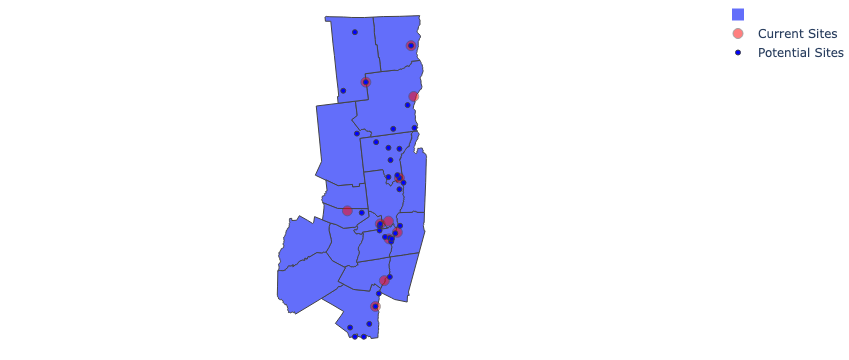

In [43]:
from urllib.request import urlopen
import json
import requests
df_va_facility = main_df[main_df.has_VA_facility == True]
# NY County
url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/new-york-counties.geojson'
with urlopen(url) as response:
    ny_county_json = json.load(response)

ny_county_json['features'] = [city for city in ny_county_json['features'] if city['properties']['name'].replace(" County", "") in main_df.county.unique().tolist()]    

county = []
for i in range(len(ny_county_json['features'])):
    name = ny_county_json['features'][i]['properties']['name']
    county.append(name)

import pandas as pd
import numpy as np
df = pd.DataFrame({'county': county})
df['county'] = df['county'].astype(str)


import plotly.express as px

fig = px.choropleth( df,
                    geojson= ny_county_json,
                    locations='county',
                    featureidkey="properties.name",
                    projection="mercator",
                    )

# add lat lon markers
fig.add_scattergeo(name = "Current Sites", lat=df_va_facility['latitude'], lon=df_va_facility['longitude'],
                   hovertext=df_va_facility['county'],
                   mode='markers',
                   marker=dict(
                       line_width=1,
                       color="red",
                       opacity=0.5,
                       size=10
                   )
                  )

fig.add_scattergeo(name = "Potential Sites", lat=visn_02_all_community_facilities['latitude'], lon=visn_02_all_community_facilities['longitude'],
                   hovertext=visn_02_all_community_facilities['zip'],
                   mode='markers',
                   marker=dict(
                       line_width=1,
                       color="blue",
                       opacity=1,
                       size=5
                   )
                  )



fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

# Optimization Model

## Define relevant functions

In [5]:
from geopy.distance import geodesic

def zip_distance(zip1, zip2):
    loc1 = (main_df[main_df.zip == zip1].latitude.values[0], main_df[main_df.zip == zip1].longitude.values[0]) 
    loc2 = (main_df[main_df.zip == zip2].latitude.values[0], main_df[main_df.zip == zip2].longitude.values[0])
    return geodesic(loc1, loc2).mi

def online_review(zip_c):
    return visn_02_all_community_facilities[visn_02_all_community_facilities.zip == zip_c]['Online Review'].values[0]

def cost_new_fac(zip_c):
    return visn_02_all_community_facilities[visn_02_all_community_facilities.zip == zip_c]['Avg. Cost'].values[0]

def get_population(zip_c):
    return main_df[main_df.zip == zip_c].VA_Enrollees.values[0]


## Define variables and parameters

In [33]:
# Import PuLP library
import pulp
import random

zip_codes = main_df.zip.tolist() # List of all zip codes
new_cbocs = visn_02_all_community_facilities.zip.tolist() # List of zip codes for all potential sites for new CBOCs
existing_cbocs = visn_2_eastern_facilities.zip.tolist() # List of zip codes for all existing operational CBOCs
existing_cbocs = [int(x) for x in existing_cbocs]
population = {z: get_population(z) for z in zip_codes} # Veteran population in each zip code

# Define decision variables
open_new_cboc = pulp.LpVariable.dicts("open_new_cboc", new_cbocs, lowBound=0, upBound=1, cat=pulp.LpBinary) # Determine if a new CBOC should be opened or not
upgrade_albany = pulp.LpVariable("upgrade_albany", lowBound=0, upBound=1, cat=pulp.LpBinary) #Determine if the Facility at Albany should be upgraded or not
prop_assigned_albany = pulp.LpVariable.dicts("prop_assigned_albany", zip_codes, lowBound=0, upBound=1) # Determine the proportion of veterans to be assigned from each zip code to the Albany facility
prop_assigned_new_cbocs = pulp.LpVariable.dicts("prop_assigned_new_cbocs", [(i,j) for i in zip_codes for j in new_cbocs], 0, 1) # Determine the proportion of veterans to be assigned from each zip code to each potential new CBOC
prop_assigned_existing_cbocs = pulp.LpVariable.dicts("prop_assigned_existing_cbocs", [(i,j) for i in zip_codes for j in existing_cbocs], 0, 1) # Determine the proportion of veterans to be assigned from each zip code to the existing CBOCs

# Define cost parameters
cost_new_cboc = {c: cost_new_fac(c) for c in new_cbocs}  #  cost of opening new CBOCs
cost_exist_cboc = 100000 # Cost of operating existing CBOCs
cost_upgrade = 10000000 # Cost of Upgrading the Facility at Albany

# Define drive time parameters
max_drive_time = 20  # Maximum allowable drive miles for any veteran 
drive_time_existing = {z: zip_distance(12009, z) for z in zip_codes} # Dictionary of drive times from each zip code to the Albany facility
drive_time_new_cboc = {c: {z: zip_distance(c, z) for z in zip_codes} for c in new_cbocs}  # Dictionary of drive times from each zip code to potential new CBOCs
drive_time_existing_cboc = {c: {z: zip_distance(c, z) for z in zip_codes} for c in existing_cbocs}  # Dictionary of drive times from each zip code to an existing CBOC

# Define review score variables
review_new_cboc = {c: round(random.uniform(0.5, 4.5), 1) for c in new_cbocs}  # Online reviews for each potential new CBOC
review_existing_cboc = {c: round(random.uniform(0.5, 4.5), 1) for c in existing_cbocs}  # Online reviews for all existing CBOCs, which is assigned to be the same value for all existing CBOCs


In [42]:
max(cost_new_cboc.values())

2000000.0

## Define objective function and constraints

In [47]:
# Define the optimization problem
prob = pulp.LpProblem("Facility_Assignment_Optimization", pulp.LpMinimize)

# Define the objective function
total_cost = sum(open_new_cboc[c] * cost_new_cboc[c] for c in new_cbocs) + upgrade_albany * cost_upgrade
total_coverage = 0
for z in zip_codes:
    total_coverage += prop_assigned_albany[z]*population[z] + sum(prop_assigned_new_cbocs[(z,c)]*population[z] for c in new_cbocs) + sum(prop_assigned_existing_cbocs[(z,c)]*population[z] for c in existing_cbocs)

# Meeting decision: normalize these to a comparable scale
prob += total_cost - total_coverage

# Define constraints
# Constraint 0: Budget Constraint
#prob += total_cost <= 350000


# Constraint 1: Ensure that the total population of people assigned is at least a certain amount
prob += sum(prop_assigned_albany[z]*population[z] for z in zip_codes) + sum(prop_assigned_new_cbocs[(z,c)]*population[z] for c in new_cbocs for z in zip_codes) + sum(prop_assigned_existing_cbocs[(z,c)]*population[z] for c in existing_cbocs for z in zip_codes) >= 0.5*sum(population.values()) 
print("Finished Loading Constraint 1")

# Constraint 2: Ensure that people are only assigned to a facility (new, existing, or Albany) if the driving distance between their zip code and the relevant facility is under the maximum allowable drive time
for z in zip_codes:
    prob += prop_assigned_albany[z] <= (1 if drive_time_existing[z] <= max_drive_time else 0)
    prob += sum(prop_assigned_new_cbocs[(z,c)] for c in new_cbocs) <= (1 if drive_time_new_cboc[c][z] <= max_drive_time else 0 for c in new_cbocs)
    prob += sum(prop_assigned_existing_cbocs[(z,c)] for c in existing_cbocs) <= (1 if drive_time_existing_cboc[c][z] <= max_drive_time else 0 for c in existing_cbocs)
print("Finished Loading Constraint 2")

# Constraint 3: Ensure that the average review experienced by veterans from any zip code is at least 3
for z in zip_codes:
    prob += (prop_assigned_albany[z] * 2.5 + 
          sum(prop_assigned_new_cbocs[(z,c)] * review_new_cboc[c] for c in new_cbocs) + 
          sum(prop_assigned_existing_cbocs[(z,c)] * review_existing_cboc[c] for c in existing_cbocs)) >= 4 * (prop_assigned_albany[z] + sum(prop_assigned_new_cbocs[(z,c)] for c in new_cbocs) + 
          sum(prop_assigned_existing_cbocs[(z,c)] for c in existing_cbocs))
print("Finished Loading Constraint 3")

    

# Constraint 4: Ensure that the total proportion of veterans assigned to all facilities is not greater than 1
for z in zip_codes:
    prob += prop_assigned_albany[z] + sum(prop_assigned_new_cbocs[(z,c)] for c in new_cbocs) + sum(prop_assigned_existing_cbocs[(z,c)] for c in existing_cbocs) <= 1
print("Finished Loading Constraint 4")

# Constraint 5: Ensure that either a new CBOC is opened or the Albany facility is upgraded
prob += sum(open_new_cboc[c] for c in new_cbocs) + upgrade_albany >= 1
print("Finished Loading Constraint 5")


# Constraint 6: Only open new CBOC if people are assigned
for c in new_cbocs:
    prob += open_new_cboc[c] <= sum(prop_assigned_new_cbocs[(z,c)] for z in zip_codes)
    

# # Constraint 7: Don't partner with a new facility that is within 25 miles of any other facility
for c1 in new_cbocs:
    for c2 in existing_cbocs:
        prob += open_new_cboc[c1] <= (0 if zip_distance(c1, c2) <= 1 else 1)



Finished Loading Constraint 1
Finished Loading Constraint 2
Finished Loading Constraint 3
Finished Loading Constraint 4
Finished Loading Constraint 5


## Solve the model and obtain output

In [48]:

# Solve the optimization problem
prob.solve()
print("Began Optimizing")
# Print the status of the solution
print("Status:", pulp.LpStatus[prob.status])

# Print the total cost
print("Total cost:", pulp.value(prob.objective))

# Print the decision variables
all_new_open = []
for c in new_cbocs:
    if pulp.value(open_new_cboc[c]) == 1:
        print("open_new_cboc[{}]: {}".format(c, pulp.value(open_new_cboc[c])))
        all_new_open.append(c)
                
print("upgrade_albany: {}".format(pulp.value(upgrade_albany)))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/siddharthanambiar/opt/anaconda3/envs/Booz-Marketing/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/3n/cxbbcc295t16bdrdqrtbg5vh0000gp/T/574f932c7a0147d4a67f012e54a2d722-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/3n/cxbbcc295t16bdrdqrtbg5vh0000gp/T/574f932c7a0147d4a67f012e54a2d722-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2997 COLUMNS
At line 138676 RHS
At line 141669 BOUNDS
At line 165864 ENDATA
Problem MODEL has 2992 rows, 24194 columns and 113245 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 331750 - 0.04 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 1450 rows, 15854 columns (30 integer (30 of which binary)) and 70994 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution fo

In [45]:
all_new_open = [12010]

## Visualize the solution

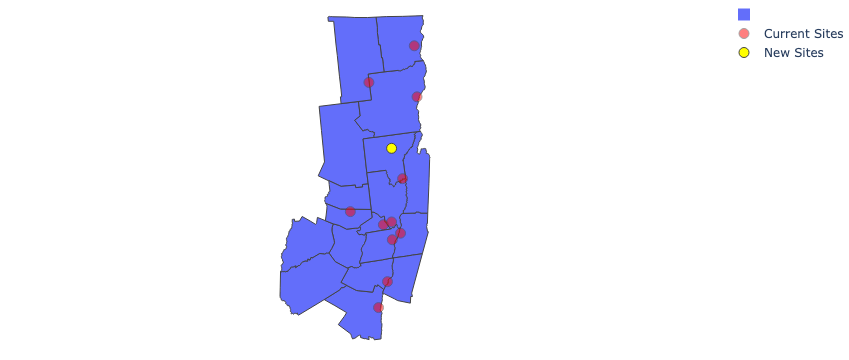

In [49]:
from urllib.request import urlopen
import json
import requests
df_va_facility = main_df[main_df.has_VA_facility == True]
# NY County
url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/new-york-counties.geojson'
with urlopen(url) as response:
    ny_county_json = json.load(response)

ny_county_json['features'] = [city for city in ny_county_json['features'] if city['properties']['name'].replace(" County", "") in main_df.county.unique().tolist()]    

county = []
for i in range(len(ny_county_json['features'])):
    name = ny_county_json['features'][i]['properties']['name']
    county.append(name)

import pandas as pd
import numpy as np
df = pd.DataFrame({'county': county})
df['county'] = df['county'].astype(str)


import plotly.express as px

fig = px.choropleth( df,
                    geojson= ny_county_json,
                    locations='county',
                    featureidkey="properties.name",
                    projection="mercator",
                    )

# add lat lon markers
fig.add_scattergeo(name = "Current Sites", lat=df_va_facility['latitude'], lon=df_va_facility['longitude'],
                   hovertext=df_va_facility['county'],
                   mode='markers',
                   marker=dict(
                       line_width=1,
                       color="red",
                       opacity=0.5,
                       size=10
                   )
                  )


new_cboc_df = visn_02_all_community_facilities[visn_02_all_community_facilities.zip.isin(all_new_open)]
fig.add_scattergeo(name = "New Sites", lat=new_cboc_df['latitude'], lon=new_cboc_df['longitude'],
                   mode='markers',
                   marker=dict(
                       line_width=1,
                       color="yellow",
                       opacity=1,
                       size=10
                   )
                  )



fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [50]:
# calculate the total coverage
total_assigned = sum(pulp.value(prop_assigned_albany[z])*population[z] for z in zip_codes) + sum(pulp.value(prop_assigned_new_cbocs[(z,c)])*population[z] for c in new_cbocs for z in zip_codes) + sum(pulp.value(prop_assigned_existing_cbocs[(z,c)])*population[z] for c in existing_cbocs for z in zip_codes)
total_population = sum(population.values())
total_coverage = total_assigned / total_population

# print the total coverage
print("Total coverage: {:.2f}%".format(total_coverage * 100))

Total coverage: 90.21%


In [51]:
tot_cost = sum(pulp.value(open_new_cboc[c]) * cost_new_cboc[c] for c in new_cbocs) + pulp.value(upgrade_albany) * cost_upgrade
print("Total Cost: ", tot_cost)

Total Cost:  375000.0


# Describe the Data

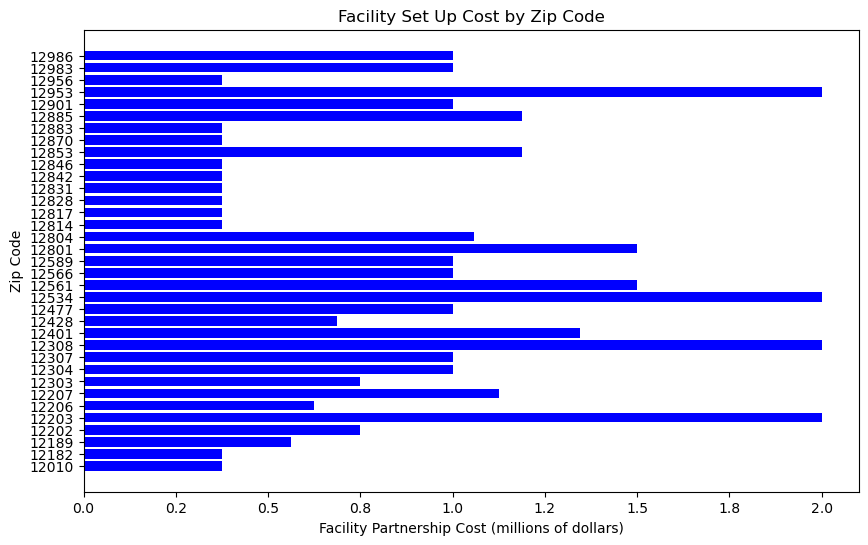

In [159]:
# Import required packages
import matplotlib.pyplot as plt

# Create dictionary of zip codes and facility set up cost
zip_cost = cost_new_cboc

# Convert dictionary to a pandas DataFrame
df = pd.DataFrame(list(zip_cost.items()), columns=['zip', 'cost'])
df.zip = df.zip.astype(str)

# Create horizontal bar chart with facility set up cost in millions of dollars
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(df['zip'], df['cost']/1000000, color='b')
ax.set_xlabel('Facility Partnership Cost (millions of dollars)')
ax.set_ylabel('Zip Code')
ax.set_title('Facility Set Up Cost by Zip Code')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.show()




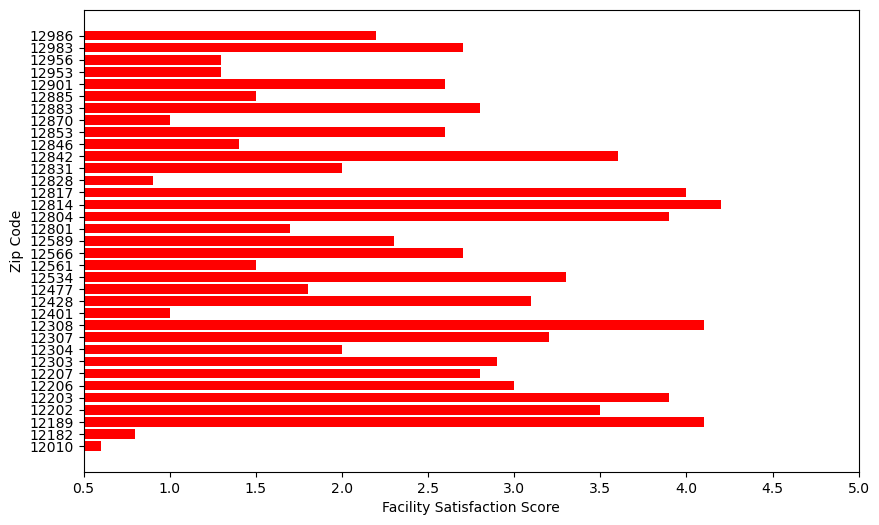

In [161]:
# Import required packages
import matplotlib.pyplot as plt

# Create dictionary of zip codes and facility set up cost
zip_review = review_new_cboc

# Convert dictionary to a pandas DataFrame
df = pd.DataFrame(list(zip_review.items()), columns=['zip', 'review'])
df.zip = df.zip.astype(str)

# Create horizontal bar chart with facility set up cost in millions of dollars
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(df['zip'], df['review'], color='r')
ax.set_xlabel('Facility Satisfaction Score')
ax.set_ylabel('Zip Code')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.set_xlim([0.5, 5])
plt.show()


